In [157]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, value_and_grad
from jax import nn

import numpy as np
import os
import dill

In [296]:
ex_name = "ex3-1D_cubic"

# load true functions
with open(f"true_functions/{ex_name}.pkl", "rb") as f:
    true_functions = dill.load(f)

true_drift = true_functions["drift"]
true_diffusion = true_functions["diffusion"]

# load data
data_name = f"{ex_name}_time0.01_SS0.01_ntraj10000"
training_data = np.load(f"training_data/{data_name}.npz")

n_dimensions = training_data["n_dimensions"]
trajectory_step_size = training_data["step_size"]
xlim = training_data["xlim"]
trajectories = training_data["trajectories"]

print(trajectories.shape)

(10000, 1, 2)


In [297]:
random_seed = 1
rng = np.random.default_rng(random_seed)

# subsample data
step_size = 0.01
sampled_trajectories = trajectories[:, :, ::int(step_size/trajectory_step_size)]

x_data = sampled_trajectories[:, :, :-1].reshape(-1, n_dimensions)
y_data = sampled_trajectories[:, :, 1:].reshape(-1, n_dimensions)

step_sizes = np.zeros((x_data.shape[0], 1)) + step_size

print(x_data.shape)

D = x_data.shape[1]
tri = D*(D+1)/2
h = step_size

key = random.PRNGKey(0)

diffusion_type = "diagonal"

print(jnp.min(x_data), jnp.max(x_data))
print(jnp.min(y_data), jnp.max(y_data))

(10000, 1)
-1.9998207 1.9993901
-2.063387 2.1206636


In [298]:
# functions to be learned
def S(omega, x):
    return jnp.cos(x @ omega)

# def beta(params, x):
#     beta_ = jnp.real(jnp.matmul(S(params['omega'], x), params['amp']))
#     return beta_

# def beta(params, x):
#     features = S(params["omega"], x)
#     return jax.nn.softplus(features @ params["amp"]) + 1e-3

def beta(params, x):
    x_proj = x @ params["omega"]
    features = jnp.concatenate([jnp.cos(x_proj), jnp.sin(x_proj)], axis=-1)
    return features @ params["amp"]

# def beta(params, x):
#     h = jnp.tanh(x @ params['w1'] + params['b1'])
#     return h @ params['w2'] + params['b2']

# def covariance(params, diffusion_type, x):
    
#     covariance_vectors = beta(params, x)
#     #jax.debug.print("test {}", covariance_vectors)
#     N, T = covariance_vectors.shape
#     D = ((jnp.sqrt(1 + 8 * T) - 1) / 2).astype(int)

#     if diffusion_type == "diagonal":
#         covariance_matrix = jax.vmap(jnp.diag)(covariance_vectors)
#     else:
#         LT_idx = jnp.tril_indices(D)
#         LT = jnp.zeros((N, D, D))
#         LT = LT.at[:, LT_idx[0], LT_idx[1]].set(covariance_vectors[:, :T])
#         UT = jnp.swapaxes(LT, 1, 2)
#         diag = jnp.diagonal(LT, axis1=1, axis2=2)
#         covariance_matrix = LT + UT - jnp.eye(D) * diag[:, None, :]

#     return covariance_matrix

# def diffusion(params, diffusion_type, x):
#     covariance_ = covariance(params, diffusion_type, x)
    
#     if diffusion_type == "diagonal":
#         diffusion_matrix = jnp.sqrt(covariance_)
#         #jax.debug.print("test {}", diffusion_matrix)
#     elif diffusion_type == "triangular":
#         diffusion_matrix = jax.vmap(jnp.linalg.cholesky)(covariance_)
#     else:
#         def matrix_sqrtm(mat):
#             vals, vecs = jnp.linalg.eigh(mat)
#             sqrt_vals = jnp.sqrt(jnp.clip(vals, a_min=0.0))
#             return (vecs * sqrt_vals) @ vecs.T
#         diffusion_matrix = jax.vmap(matrix_sqrtm)(covariance_)
              
#     return diffusion_matrix

def drift(params, x):
    drift_ = beta(params, x)
    return drift_

def diffusion(params, x):
    raw = jax.nn.softplus(beta(params, x)) + 1e-3
    mat = raw.reshape((-1, D, D))
    # Make it SPD: output = L @ L.T
    return jnp.matmul(mat, jnp.transpose(mat, (0, 2, 1))) + 1e-3 * jnp.eye(D)

In [299]:
# --- Define drift NN (f_theta) ---
def init_drift_params(key):
    k1, k2 = random.split(key)
    return {
        "omega": random.normal(k1, (D, 32)) * 0.1,
        "amp": random.normal(k2, (64, D)) * 0.01
    }
    
# --- Define diffusion NN (sigma_theta') that outputs lower-triangular matrix ---
def init_diffusion_params(key):
    k1, k2 = random.split(key)
    return {
        "omega": random.normal(k1, (D, 32)) * 0.1,
        "amp": random.normal(k2, (64, D * D)) * 0.01
    }



# def init_diffusion_params(key):
#     k1, k2 = random.split(key)
#     return {
#         "w1": random.normal(k1, (D, 32)) * 0.1,
#         "b1": jnp.zeros(32),
#         "w2": random.normal(k2, (32, D * D)) * 0.1,
#         "b2": jnp.zeros(D * D)
#     }


# # --- Define drift NN (f_theta) ---
# def init_drift_params(key):
#     k1, k2 = random.split(key)
#     return {
#         "w1": random.normal(k1, (D, 32)) * 0.1,
#         "b1": jnp.zeros(32),
#         "w2": random.normal(k2, (32, D)) * 0.1,
#         "b2": jnp.zeros(D)
#     }
    

In [300]:
# --- Loss function ---
def nll_loss(params_drift, params_diff, x0, x1, h):
    f = drift(params_drift, x0)
    #Sigma = diffusion(params_diff, diffusion_type, x0) * h 
    Sigma = diffusion(params_diff, x0) * h 
    delta = x1 - x0 - h * f  # (N, D)

    def single_loss(d, S):
        inv_S = jnp.linalg.inv(S)
        logdet = jnp.linalg.slogdet(S)[1]
        return 0.5 * d @ inv_S @ d + 0.5 * logdet + 0.5 * D * jnp.log(2 * jnp.pi)

    losses = jax.vmap(single_loss)(delta, Sigma)
    return jnp.mean(losses)

In [301]:
# --- Initialize ---
key1, key2, key3 = random.split(key, 3)
params_drift = init_drift_params(key1)
params_diff = init_diffusion_params(key2)

# --- Optimizers ---
opt = optax.adam(1e-3)
    
opt_state_drift = opt.init(params_drift)
opt_state_diff = opt.init(params_diff)

# --- Training step ---
@jax.jit
def train_step(params_drift, params_diff, opt_state_drift, opt_state_diff, x0, x1, h):
    # jax.debug.print("drift output {}", drift(params_drift, x0[:1]))
    # jax.debug.print("diff output {}", diffusion(params_diff, diffusion_type, x0[:1]))
    loss, grads = value_and_grad(nll_loss, argnums=(0, 1))(params_drift, params_diff, x0, x1, h)
    jax.debug.print("Drift grad norm: {}", optax.global_norm(grads[0]))
    jax.debug.print("Diff grad norm:  {}", optax.global_norm(grads[1]))

    grads_drift, grads_diff = grads

    updates_drift, opt_state_drift = opt.update(grads_drift, opt_state_drift)
    updates_diff, opt_state_diff = opt.update(grads_diff, opt_state_diff)

    params_drift = optax.apply_updates(params_drift, updates_drift)
    params_diff = optax.apply_updates(params_diff, updates_diff)

    return params_drift, params_diff, opt_state_drift, opt_state_diff, loss

In [302]:
# --- Training loop ---
for epoch in range(10000):
    params_drift, params_diff, opt_state_drift, opt_state_diff, loss = train_step(
        params_drift, params_diff, opt_state_drift, opt_state_diff, x_data, y_data, h
    )
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss:.4f}")

Drift grad norm: 0.1424015760421753
Diff grad norm:  1.5213491916656494
Epoch 0: Loss = -1.3669
Drift grad norm: 0.1451936811208725
Diff grad norm:  1.4295449256896973
Drift grad norm: 0.14797474443912506
Diff grad norm:  1.3310328722000122
Drift grad norm: 0.15072067081928253
Diff grad norm:  1.2256863117218018
Drift grad norm: 0.1534019261598587
Diff grad norm:  1.1134858131408691
Drift grad norm: 0.1559816151857376
Diff grad norm:  0.9945681691169739
Drift grad norm: 0.1584138423204422
Diff grad norm:  0.8692926168441772
Drift grad norm: 0.16064245998859406
Diff grad norm:  0.7383173704147339
Drift grad norm: 0.16260001063346863
Diff grad norm:  0.602699875831604
Drift grad norm: 0.16420689225196838
Diff grad norm:  0.4640580415725708
Drift grad norm: 0.16537125408649445
Diff grad norm:  0.3249029517173767
Drift grad norm: 0.16599078476428986
Diff grad norm:  0.18997956812381744
Drift grad norm: 0.16595719754695892
Diff grad norm:  0.07998013496398926
Drift grad norm: 0.165164157748

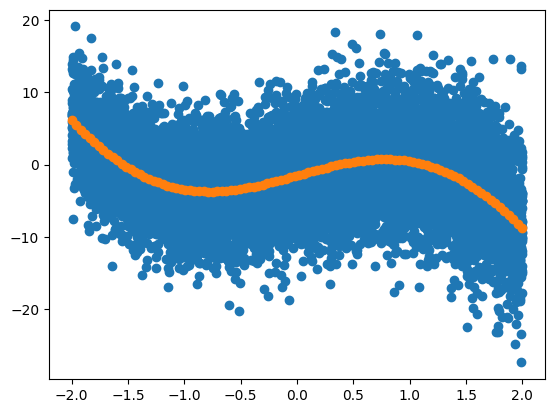

In [305]:
import matplotlib
from matplotlib import pyplot as plt

x_test = jnp.linspace(-2, 2, 100)[:, None]

plt.scatter(x_data, (y_data - x_data)/h)
plt.scatter(x_test, beta(params_drift, x_test))


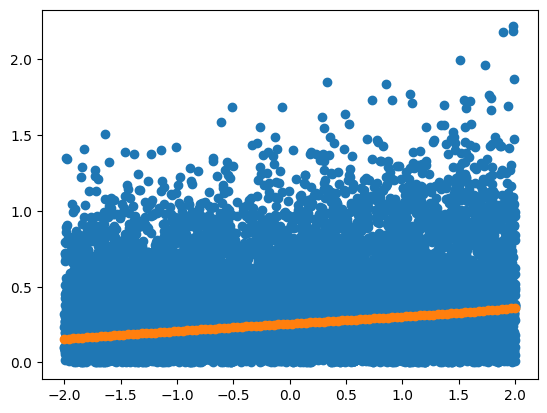

In [304]:
diffusion_points = abs((y_data - x_data - h*drift(params_drift, x_data))*h**(-0.5))
plt.scatter(x_data, diffusion_points)
#plt.scatter(x_test, diffusion(params_diff, diffusion_type, x_test))
plt.scatter(x_test, diffusion(params_diff, x_test))
